In [1]:
#rebuild tensorflow with comiler flags
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python.keras.metrics import Metric

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings

# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
#Import CO2 emissions data - OWID
data = pd.read_csv('../Data/carbon-emissions/owid-co2-data.csv')

#Observe data shape and head
print(data.shape)

(25204, 58)


In [3]:
data.head()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,0.002,NaN,0.0,0.015,0.0,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,NaN,0.002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.015,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,NaN,475.0,0.070,NaN,0.011,NaN,0.0,0.099,0.0,0.009,NaN,NaN,0.021,NaN,NaN,NaN,0.063,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.036,NaN,NaN,0.063,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,NaN,8.7,0.007,NaN,0.012,NaN,0.0,0.191,0.0,0.010,NaN,NaN,0.026,NaN,NaN,NaN,0.066,NaN,NaN,0.003,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.061,NaN,NaN,0.129,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,NaN,0.0,0.000,NaN,0.012,NaN,0.0,0.282,0.0,0.009,NaN,NaN,0.032,NaN,NaN,NaN,0.060,NaN,NaN,0.004,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.093,NaN,NaN,0.189,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,NaN,16.0,0.015,NaN,0.013,NaN,0.0,0.388,0.0,0.010,NaN,NaN,0.038,NaN,NaN,NaN,0.068,NaN,NaN,0.005,NaN,NaN,0.008,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.131,NaN,NaN,0.257,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [4]:
data.tail()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
25199,ZWE,Zimbabwe,2016,10.738,12.153,-12.17,-1.488,1.415,0.765,0.866,0.03,736.467,0.05,0.512,0.580,0.226,6.959,0.639,NaN,NaN,3.139,NaN,0.046,0.496,NaN,NaN,0.224,NaN,13.18,0.04,0.05,NaN,NaN,0.03,NaN,18.188,585.104,NaN,NaN,133.175,NaN,0.05,0.08,NaN,NaN,0.02,NaN,65.98,4.703,11.92,0.85,6.55,0.467,14030338.0,2.096179e+10,47.5,3385.574,1.889
25200,ZWE,Zimbabwe,2017,9.582,11.248,-10.77,-1.156,1.666,0.673,0.790,0.03,746.049,0.05,0.437,0.512,NaN,5.665,0.678,NaN,NaN,3.239,NaN,0.048,0.398,NaN,NaN,0.228,NaN,17.39,0.05,0.04,NaN,NaN,0.03,NaN,18.866,590.768,NaN,NaN,136.414,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14236599.0,2.194784e+10,NaN,NaN,NaN
25201,ZWE,Zimbabwe,2018,11.854,13.163,23.72,2.273,1.308,0.821,0.912,0.03,757.903,0.05,0.522,0.580,NaN,7.101,0.697,NaN,NaN,4.056,NaN,0.048,0.492,NaN,NaN,0.281,NaN,11.04,0.04,0.05,NaN,NaN,0.03,NaN,19.564,597.869,NaN,NaN,140.470,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14438812.0,2.271535e+10,NaN,NaN,NaN
25202,ZWE,Zimbabwe,2019,10.949,12.422,-7.64,-0.905,1.473,0.748,0.848,0.03,768.852,0.05,NaN,NaN,NaN,6.020,0.697,NaN,NaN,4.232,NaN,0.048,0.411,NaN,NaN,0.289,NaN,13.45,0.04,0.04,NaN,NaN,0.03,NaN,20.261,603.889,NaN,NaN,144.702,NaN,0.05,0.08,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14645473.0,NaN,NaN,NaN,NaN
25203,ZWE,Zimbabwe,2020,10.531,NaN,-3.82,-0.418,NaN,0.709,NaN,0.03,779.383,0.05,NaN,NaN,NaN,6.257,0.697,NaN,NaN,3.576,NaN,0.047,0.421,NaN,NaN,0.241,NaN,NaN,0.04,0.04,NaN,NaN,0.03,NaN,20.959,610.146,NaN,NaN,148.279,NaN,0.05,0.08,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,other_co2_per_capita,trade_co2_share,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,share_global_other_co2,cumulative_cement_co2,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_oil_co2,cumulative_other_co2,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
count,25204.000000,23949.000000,3976.000000,24931.000000,23585.000000,3976.000000,23307.000000,3976.000000,23949.000000,2.394900e+04,23949.000000,15389.000000,3761.000000,9141.000000,17188.000000,12248.000000,4382.000000,8845.000000,20539.000000,1999.000000,12218.000000,16860.000000,4381.000000,8835.000000,20181.000000,1999.000000,3976.000000,12248.000000,17188.00000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,12248.000000,17188.000000,4382.000000,8845.000000,20539.000000,1999.000000,5208.000000,5155.000000,5211.000000,5157.000000,5211.000000,5157.000000,2.287800e+04,1.353800e+04,8690.000000,8681.000000,6803.000000
mean,1953.225797,267.861942,916.755170,21.098600,5.146889,-2.415624,4.170811,6.567721,4.983979,1.035710e+04,5.126531,0.421795,0.370038,0.238931,175.358171,12.888607,15.000326,108.750774,106.254381,15.753891,0.113037,1.551520,0.875319,1.413336,2.635498,0.080168,22.961190,4.419452,6.98983,5.861506,5.405564,2.993497,14.295183,307.761167,8791.767180,425.698588,2587.096729,3296.584230,293.588436,4.462228,7.211834,5.621670,5.242400,3.001620,13.403622,441.481429,8.099506,82.253370,2.046923,29.308135,0.606690,7.072322e+07,2.877088e+11,1569.083895,25568.487454,1.850291
std,53.791369,1521.680894,3373.348275,702.565991,55.259760,182.444942,14.912201,6.927957,17.704994,6.120603e+04,18.480079,0.483864,0.265374,0.233550,786.106838,77.258563,40.471977,441.064563,602.683622,39.385589,0.148907,2.552112,5.477923,3.654290,15.129275,0.055779,45.055039,15.950613,20.76197,14.874259,18.408881,12.018682,28.570911,1706.159528,39131.720328,1320.911296,12347.690600,21645.263301,777.706862,15.685264,21.636504,15.021334,18.926934,12.134102,27.019447,3089.039496,9.387477,566.702756,3.534126,199.291118,0.844671,3.795858e+08,2.180094e+12,9066.102799,33319.956208,1.575161
min,1750.000000,0.000000,0.197000,-99.640000,-1895.244000,-1657.998000,0.000000,0.055000,0.000000,0.000000e+00,0.000000,0.000000,0.006000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-96.760000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-85.620000,-50.487000,0.000000,0.000000,0.000000,0.000000,1.490000e+03,5.543200e+07,0.000000,0.000000,0.050000
25%,1925.000000,0.528000,10.319750,-0.450000,-0.011000,-0.892500,0.253000,1.240250,0.010000,6.992000e+00,0.000000,0.140000,0.216000,0.178000,0.322000,0.129000,0.253250,0.385000,0.311000,0.747500,0.020000,0.054000,0.021000,0.031000,0.121000,0.036000,-1.757500,0.050000,0.01000,0.090000,0.030000,0.010000,0.300000,1.613000,5.516250,4.071250,3.239000,3.921000,7.709000,0.040000,0.000000,0.060000,0.010000,0.010000,0.190000,8.162500,2.514000,2.150000,0.715000,0.535000,0.228000,1.291899e+06,9.828867e+09,6.997000,3270.369000,0.856000
50%,1967.00

## Data Cleaning and Preprocessing  

In [6]:
#check for null values
data.isnull().sum()

iso_code                                3256
country                                    0
year                                       0
co2                                     1255
consumption_co2                        21228
co2_growth_prct                          273
co2_growth_abs                          1619
trade_co2                              21228
co2_per_capita                          1897
consumption_co2_per_capita             21228
share_global_co2                        1255
cumulative_co2                          1255
share_global_cumulative_co2             1255
co2_per_gdp                             9815
consumption_co2_per_gdp                21443
co2_per_unit_energy                    16063
coal_co2                                8016
cement_co2                             12956
flaring_co2                            20822
gas_co2                                16359
oil_co2                                 4665
other_industry_co2                     23205
cement_co2

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             21948 non-null  object 
 1   country                              25204 non-null  object 
 2   year                                 25204 non-null  int64  
 3   co2                                  23949 non-null  float64
 4   consumption_co2                      3976 non-null   float64
 5   co2_growth_prct                      24931 non-null  float64
 6   co2_growth_abs                       23585 non-null  float64
 7   trade_co2                            3976 non-null   float64
 8   co2_per_capita                       23307 non-null  float64
 9   consumption_co2_per_capita           3976 non-null   float64
 10  share_global_co2                     23949 non-null  float64
 11  cumulative_co2              

We focused on post-1950 data for our comparative analysis and global EDA since some countries are missing significant data before that time. Major carbon emitting countries' emission activites intensified post 1950 period, especially India. For our modelling process, however, focusing on India, the data form 1878 is continous, so we include all data for India from 1900. First, We'll be predicting and Forecasting the per capita CO2 emissions for India

In [8]:
#only include India co2 per capita data post-1900
df_India = data
df_India = df_India[df_India['year'] >= 1900]
df_India = df_India[df_India['country'] == 'India']
df_India = df_India[['year', 'co2_per_capita']]

#observe shape of reformatted df
print(df_India.shape)

(121, 2)


## Model

**Reporducibility** is extremely important as the parameter makes sure that when code is re-run, produces similar results

In [9]:
#fix random seed so that our results reproducibility
np.random.seed()

In [10]:
df_India.dtypes

year                int64
co2_per_capita    float64
dtype: object

**Normalize Input**

As with other deep learning problems, we can help neural network learn more rapidly by normalizing the inputs between 0 and 1. We will use `MinMaxScaler` for normalizing the input

In [11]:
#normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df_India = scaler.fit_transform(df_India) #try standard scaler

In [12]:
scaled_df_India.shape

(121, 2)

**Split intro train and test sets**

In [13]:
#split train-set
train_size = int(len(scaled_df_India)*0.75)
test_size = len(scaled_df_India) - train_size
train, test = scaled_df_India[0:train_size,:], scaled_df_India[train_size:len(scaled_df_India),:]
print(len(train), len(test))

90 31


In [35]:
train.shape

(90, 2)

In [36]:
test.shape

(31, 2)

Supervised learning is the most popular way where input variables (X) and output variable (y) and an algorithm can be used to learn the mapping function from input to output

The goal is to approximate the real underlying mapping so well that when we have new input data (X), we can predict the output variables (y) for that data

Time series data need to processed to as supervised learning data and it can be phrased using slidign window approach. 

Lets convert the timeseries data into the form of supervised learning data according to the value of look_back perid, which is essentially the number of lags which are seen to predict the value at time 't'

In [26]:
X_train = []
y_train = []
memory_range = 4
for i in range(memory_range, len(train)):
    X_train.append(train[i-memory_range:i, 0])
    y_train.append(train[i, 0])
    
# Converting into numpy sequences to train the LSTM model
X_train, y_train = np.array(X_train), np.array(y_train) 

LSTM network should be fed with input data (X) with a specific array structure of form [Sample, time steps, features]

lets restructure the train and test input data to required format

In [27]:
# Reshape the training data to 3 dimensional for LSTM input.

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [28]:
X_train.shape

(86, 4, 1)

In [29]:
y_train.shape

(86,)

### Building LSTM Model

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks.

Lets stat with a minimalistic model with one LSTM layer followed by a Dense Layer

In [37]:
#create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(units = 4,
                return_sequences = True,
                input_shape = (X_train.shape[1], 1),
                activation = 'sigmoid'))
model1.add(Dense(1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 4)              96        
                                                                 
 dense_1 (Dense)             (None, 4, 1)              5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


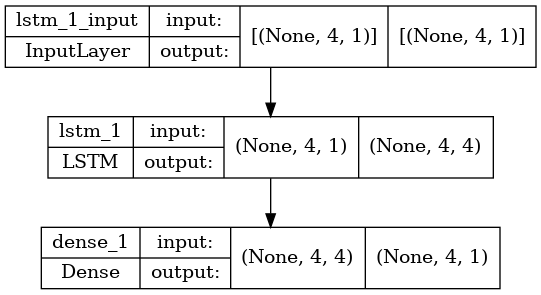

In [38]:
#print model summary
model1.summary()

#Visualize model architecture
plot_model(model1, show_shapes=True)

**evaluate baseline model**

In [39]:
#compile model
model1.compile(loss = 'mean_squared_error',
             optimizer = 'adam',
             metrics = 'mean_absolute_error')

#train model
history = model1.fit(X_train,
                   validation_data = y_train,
                   epochs = 100,
                   batch_size = 61,
                   verbose = 2,
                   shuffle = False)

history

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

***Tasks***

>- Data Preprocessing
    - _Fixing Random Seeds_
    - _Normalizing data_
    - _Train-Test Split_
    - _creating sequences_

>- Built LSTM Model (ongoing)
    - reiterate till max forecast results
        - hyperparameter tuning
    - evaluate Performance
    - Forecast Emissions for target years